<a href="https://colab.research.google.com/github/Rifqi1320/Rifqi-ML/blob/main/Week9/Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%matplotlib inline
import random
import tensorflow as tf
from d2l import tensorflow as d2l

**3.2.1. Generating the Dataset**

To keep things simple, we will construct an artificial dataset according to a linear model with additive noise. Our task will be to recover this model’s parameters using the finite set of examples contained in our dataset. We will keep the data low-dimensional so we can visualize it easily. In the following code snippet, we generate a dataset containing 1000 examples, each consisting of 2 features sampled from a standard normal distribution. Thus our synthetic dataset will be a matrix .

The true parameters generating our dataset will be and , and our synthetic labels will be assigned according to the following linear model with the noise term

In [3]:
def synthetic_data(w, b, num_examples): 
    """Generate y = Xw + b + noise."""
    X = tf.zeros((num_examples, w.shape[0]))
    X += tf.random.normal(shape=X.shape)
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1, 1))
    return X, y

true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features:', features[0],'\nlabel:', labels[0])

features: tf.Tensor([ 0.6442677  -0.04730135], shape=(2,), dtype=float32) 
label: tf.Tensor([5.663035], shape=(1,), dtype=float32)


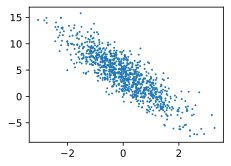

In [5]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].numpy(), labels.numpy(), 1);

**3.2.2. Reading the Dataset**

Recall that training models consists of making multiple passes over the dataset, grabbing one minibatch of examples at a time, and using them to update our model. Since this process is so fundamental to training machine learning algorithms, it is worth defining a utility function to shuffle the dataset and access it in minibatches.

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i: min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j)

In [7]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tf.Tensor(
[[ 0.19849086 -0.04596775]
 [-0.5106487   0.61563647]
 [-0.0362999   0.83044016]
 [-0.5038595   0.31313136]
 [ 0.94007146 -0.05046109]
 [ 1.7975528   0.5237352 ]
 [ 0.3062312  -0.8926602 ]
 [-0.6919757  -0.09343043]
 [ 0.27577004 -1.4846735 ]
 [ 0.02668918 -0.26895764]], shape=(10, 2), dtype=float32) 
 tf.Tensor(
[[4.756261 ]
 [1.0886728]
 [1.3031398]
 [2.1269836]
 [6.256617 ]
 [5.997755 ]
 [7.8550577]
 [3.1417975]
 [9.786499 ]
 [5.1737227]], shape=(10, 1), dtype=float32)


**3.2.3. Initializing Model Parameters**

Before we can begin optimizing our model’s parameters by minibatch stochastic gradient descent, we need to have some parameters in the first place. In the following code, we initialize weights by sampling random numbers from a normal distribution with mean 0 and a standard deviation of 0.01, and setting the bias to 0.

In [8]:
w = tf.Variable(tf.random.normal(shape=(2, 1), mean=0, stddev=0.01),
                trainable=True)
b = tf.Variable(tf.zeros(1), trainable=True)

**3.2.4. Defining the Model**

Next, we must define our model, relating its inputs and parameters to its outputs. Recall that to calculate the output of the linear model, we simply take the matrix-vector dot product of the input features and the model weights , and add the offset to each example. Note that below is a vector and is a scalar.

In [9]:
def linreg(X, w, b):  
    """The linear regression model."""
    return tf.matmul(X, w) + b

**3.2.5. Defining the Loss Function**

Since updating our model requires taking the gradient of our loss function, we ought to define the loss function first. Here we will use the squared loss function as described in Section 3.1. In the implementation, we need to transform the true value y into the predicted value’s shape y_hat. The result returned by the following function will also have the same shape as y_hat.

In [10]:
def squared_loss(y_hat, y):  
    """Squared loss."""
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 / 2

**3.2.6. Defining the Optimization Algorithm**

As we discussed in Section 3.1, linear regression has a closed-form solution. However, this is not a book about linear regression: it is a book about deep learning. Since none of the other models that this book introduces can be solved analytically, we will take this opportunity to introduce your first working example of minibatch stochastic gradient descent.

In [11]:
def sgd(params, grads, lr, batch_size): 
    """Minibatch stochastic gradient descent."""
    for param, grad in zip(params, grads):
        param.assign_sub(lr*grad/batch_size)

**3.2.7. Training**

Now that we have all of the parts in place, we are ready to implement the main training loop. It is crucial that you understand this code because you will see nearly identical training loops over and over again throughout your career in deep learning.

In [12]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as g:
            l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on l with respect to [`w`, `b`]
        dw, db = g.gradient(l, [w, b])
        # Update parameters using their gradient
        sgd([w, b], [dw, db], lr, batch_size)
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {float(tf.reduce_mean(train_l)):f}')

epoch 1, loss 0.034631
epoch 2, loss 0.000124
epoch 3, loss 0.000049


In this case, because we synthesized the dataset ourselves, we know precisely what the true parameters are. Thus, we can evaluate our success in training by comparing the true parameters with those that we learned through our training loop. Indeed they turn out to be very close to each other.

In [13]:
print(f'error in estimating w: {true_w - tf.reshape(w, true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: [1.3184547e-04 4.7683716e-05]
error in estimating b: [0.00019073]
